In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display
import datetime as dt

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [2]:
model_names = [

    "mvo_ls_small_sample_mle_mle",

]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [3]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        summary = aggregate_results(path=output_path)

        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [4]:
all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
mvo_ls_small_sample_mle_mle,-23.405573,43.990153,-0.532064,-0.623924,-44.845154,-93.601081,0.493611


## 2) Cummulative Returns of the Portfolios

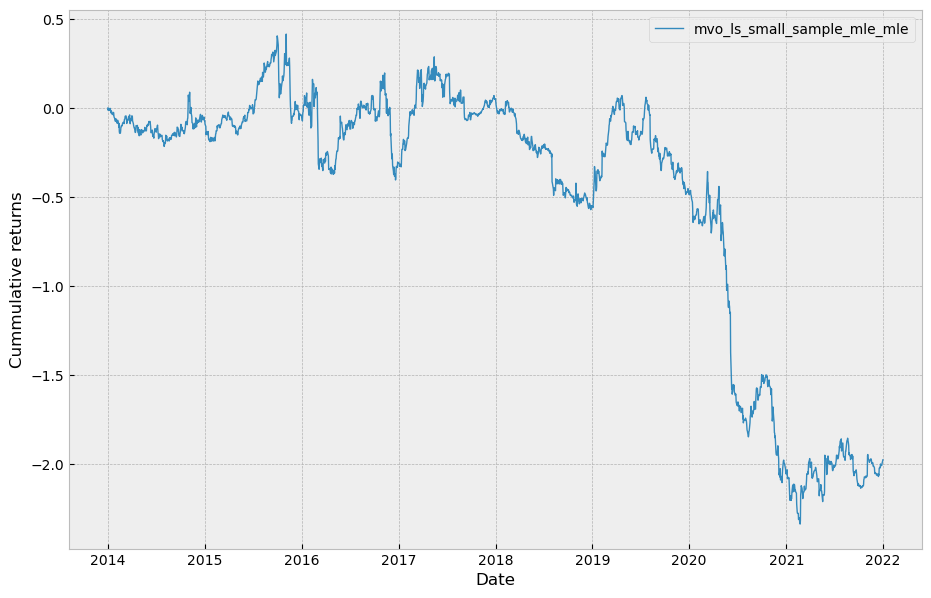

In [6]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].loc["2014-01-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Check weights

In [7]:
check_name = "mvo_ls_small_sample_mle_mle"

all_summary_df.loc[(all_summary_df["model"] == check_name), ["returns", "weights", "pnl"]].describe()

,returns,weights,pnl
count,293707.000000,2.937070e+05,293707.000000
mean,0.000493,-2.011149e-12,-0.000007
std,0.022446,4.584921e-02,0.002438
min,-0.680769,-6.086321e-01,-0.263143
25%,-0.007158,-1.256402e-04,-0.000001
50%,0.000000,3.031098e-05,0.000000
75%,0.008268,2.483984e-04,0.000001
max,0.939655,6.115400e-01,0.218438


In [12]:
all_summary_df.loc[(all_summary_df["model"] == check_name)].sort_values("returns", ascending=False)

,date,ticker,returns,weights,pnl,model
1145091,2020-03-20,GES,1.244898,7.844825e-16,9.766007e-16,rpo_ls_sample_mle_mle_cs2006
1182909,2020-06-05,LUB,1.210663,0.000000e+00,0.000000e+00,rpo_ls_sample_mle_mle_cs2006
1230607,2020-09-09,LUB,1.114286,5.651746e-14,6.297662e-14,rpo_ls_sample_mle_mle_cs2006
1183964,2020-06-08,GCI,1.021583,3.426045e-15,3.499989e-15,rpo_ls_sample_mle_mle_cs2006
1151980,2020-04-03,IO,0.939655,4.267118e-14,4.009619e-14,rpo_ls_sample_mle_mle_cs2006
...,...,...,...,...,...,...
930847,2019-01-15,PCG,-0.523593,0.000000e+00,-0.000000e+00,rpo_ls_sample_mle_mle_cs2006
1139734,2020-03-10,APA,-0.538647,0.000000e+00,-0.000000e+00,rpo_ls_sample_mle_mle_cs2006
616594,2017-04-21,OCN,-0.538889,0.000000e+00,-0.000000e+00,rpo_ls_sample_mle_mle_cs2006
373698,2015-12-18,TK,-0.584334,2.847644e-16,-1.663975e-16,rpo_ls_sample_mle_mle_cs2006


In [8]:
all_summary_df.loc[all_summary_df["model"] == check_name, ["returns", "weights", "pnl"]].describe()

,returns,weights,pnl
count,1.468535e+06,1.468535e+06,1.468535e+06
mean,4.978584e-04,1.438849e-03,1.559015e-06
std,2.144321e-02,3.790488e-02,2.490471e-03
min,-6.807690e-01,0.000000e+00,-4.086290e-01
25%,-6.905000e-03,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.003870e-17,0.000000e+00
75%,8.038000e-03,1.853542e-15,4.474891e-20
max,1.244898e+00,1.000000e+00,6.836730e-01


<Axes: title={'center': 'AA returns'}, xlabel='date'>

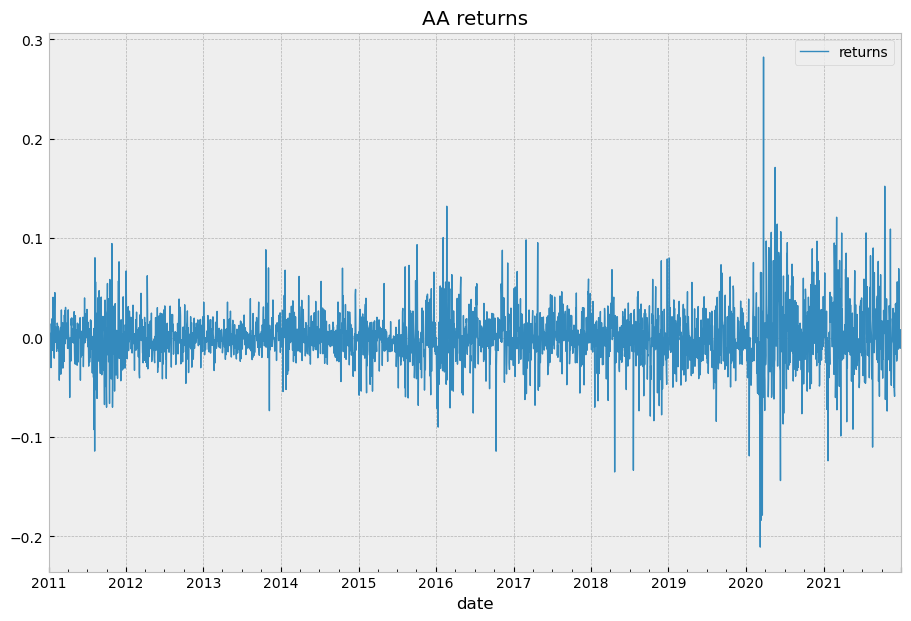

In [18]:
stock_name = "AA"

check_stock_df = all_summary_df.loc[(all_summary_df["model"] == check_name)&(all_summary_df["ticker"] == stock_name)][["date", "returns"]]
check_stock_df["date"] = pd.to_datetime(check_stock_df["date"])
check_stock_df.set_index("date", inplace=True)

check_stock_df.plot(figsize=(11, 7), title="{} returns".format(stock_name))

## 4) Check Returns from Raw Data

In [19]:
d1 = "2016-10-05"
d2 = "2016-10-06"

f1 = os.path.join(os.getcwd(), os.getcwd(), "data", "inputs", "US_CRSP_NYSE", "2016", "{}.csv.gz".format(d1).replace("-", ""))
f2 = os.path.join(os.getcwd(), os.getcwd(), "data", "inputs", "US_CRSP_NYSE", "2016", "{}.csv.gz".format(d2).replace("-", ""))
stock_name = "AA"

tmp_df1 = pd.read_csv(f1, compression='gzip', on_bad_lines='skip')
tmp_df2 = pd.read_csv(f2, compression='gzip', on_bad_lines='skip')

In [20]:
tmp_df1.loc[tmp_df1["ticker"] == stock_name]

,Unnamed: 0,ticker,open,high,low,close,volume,OPCL,pvCLCL,prevAdjClose,SPpvCLCL,sharesOut,PERMNO,SICCD,PERMCO,prevRawOpen,prevRawClose,prevAdjOpen
15,16,AA,10.25,10.41,10.17,10.4,29736798,0.014528,0.019608,10.2,0.004297,1315380,24643,3334,20060,10.06,10.2,10.06


In [21]:
tmp_df2.loc[tmp_df2["ticker"] == stock_name]

,Unnamed: 0,ticker,open,high,low,close,volume,OPCL,pvCLCL,prevAdjClose,SPpvCLCL,sharesOut,PERMNO,SICCD,PERMCO,prevRawOpen,prevRawClose,prevAdjOpen
15,16,AA,31.07,32.02,31.07,31.78,10026484,0.022594,0.01859,31.2,0.000482,438460,24643,3334,20060,10.25,10.4,30.75
